# Goal: To predict price of a particular house using information like house area, number of bedrooms, number of bathrooms, and utilities

# 1. Import necessary libraries, load datasets

## 1.1 import necessary libraries

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import stats
from scipy.stats import norm

# ML models
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV
from sklearn.model_selection import train_test_split, cross_val_score


# preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder

# metrics to evaluate regression model
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings('ignore')

## 1.2 Load datasets

In [7]:
df=pd.read_csv('train.csv') # contains features and target variable (prices)
#test_df =pd.read_csv('test.csv') # only features; 
#sample_df=pd.read_csv('sample_submission.csv') # contains target variable

In [8]:
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [9]:
df.shape

(1460, 81)

# 2. Data Processing

## 2.1 Missing values

PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
FireplaceQu      690
LotFrontage      259
GarageYrBlt       81
GarageCond        81
GarageType        81
GarageFinish      81
GarageQual        81
BsmtFinType2      38
BsmtExposure      38
BsmtQual          37
BsmtCond          37
BsmtFinType1      37
MasVnrArea         8
MasVnrType         8
Electrical         1
Id                 0
Functional         0
Fireplaces         0
KitchenQual        0
KitchenAbvGr       0
BedroomAbvGr       0
HalfBath           0
FullBath           0
BsmtHalfBath       0
TotRmsAbvGrd       0
GarageCars         0
GrLivArea          0
GarageArea         0
PavedDrive         0
WoodDeckSF         0
OpenPorchSF        0
dtype: int64


<AxesSubplot:>

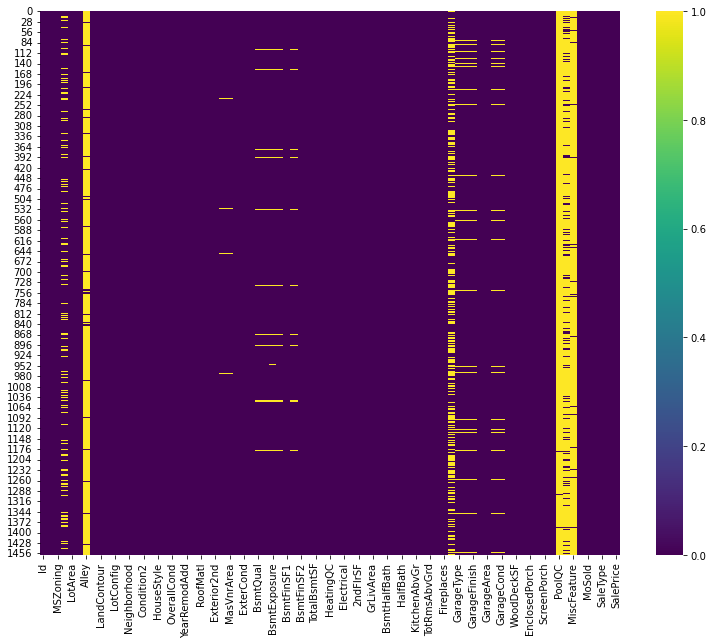

In [11]:
print(df.isnull().sum().sort_values(ascending=False)[:35]) # print sum of missing values

fig, ax = plt.subplots(figsize=(13,10))   
sns.heatmap(df.isnull(), cmap='viridis', ax=ax) # heatmap of missing values

In [12]:
df.SalePrice.describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

# 2.2 EDA

## 2.2.1 Distribution of SalePrice (target var)

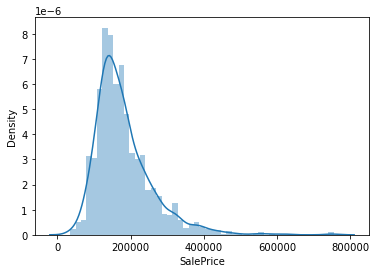

In [13]:
sns.distplot(df['SalePrice'], kde=True);

<AxesSubplot:xlabel='SalePrice', ylabel='Count'>

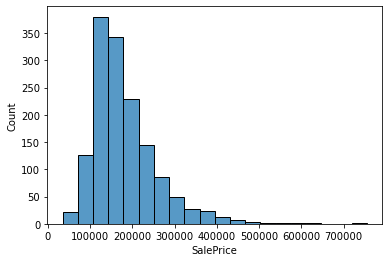

In [14]:
sns.histplot(df.SalePrice, bins=20)

In [17]:
high_price_houses=df.loc[df['SalePrice']>=500000]
high_price_houses.shape[0]

9

In [18]:
medium_price_houses=df.loc[(df['SalePrice']>=100000)& (df['SalePrice']<=200000)]
medium_price_houses.shape[0]

919

In [19]:
low_price_houses=df.loc[df['SalePrice']<=100000]
low_price_houses.shape[0]

123

### House prices plot shows positive skewness (9 houses had>500k price, 123 houses are <100k price;  What features make >500k houses pricy?

## 2.2.2 what's the skewness and kurtosis exist in SalePrice?

In [20]:
print("Skewness: %f" % df['SalePrice'].skew())
print("Kurtosis: %f" % df['SalePrice'].kurt())

Skewness: 1.882876
Kurtosis: 6.536282


# 2.3 Numeric columns

In [21]:
num_cols=df.select_dtypes(exclude='object')
num_cols.columns

Index(['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
       'MiscVal', 'MoSold', 'YrSold', 'SalePrice'],
      dtype='object')

In [22]:
num_cols.shape

(1460, 38)

In [23]:
# separate target variable
target=num_cols['SalePrice']
target.head()

0    208500
1    181500
2    223500
3    140000
4    250000
Name: SalePrice, dtype: int64

In [24]:
target.isnull().sum() # Are any missing values in SalePrice?

0

In [25]:
# all numeric features except target variable
num_cols_features=num_cols.drop(['SalePrice'],axis=1)
num_cols_features.head()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
0,1,60,65.0,8450,7,5,2003,2003,196.0,706,...,548,0,61,0,0,0,0,0,2,2008
1,2,20,80.0,9600,6,8,1976,1976,0.0,978,...,460,298,0,0,0,0,0,0,5,2007
2,3,60,68.0,11250,7,5,2001,2002,162.0,486,...,608,0,42,0,0,0,0,0,9,2008
3,4,70,60.0,9550,7,5,1915,1970,0.0,216,...,642,0,35,272,0,0,0,0,2,2006
4,5,60,84.0,14260,8,5,2000,2000,350.0,655,...,836,192,84,0,0,0,0,0,12,2008


In [26]:
num_cols_features.shape

(1460, 37)

In [27]:
# are any missing values in numeric columns?
num_cols_features.isnull().sum().sort_values(ascending=False).head(15)

LotFrontage      259
GarageYrBlt       81
MasVnrArea         8
Id                 0
WoodDeckSF         0
KitchenAbvGr       0
TotRmsAbvGrd       0
Fireplaces         0
GarageCars         0
GarageArea         0
EnclosedPorch      0
OpenPorchSF        0
HalfBath           0
3SsnPorch          0
ScreenPorch        0
dtype: int64

## 2.3.1 plotting relationship of numerical variables with target (SalePrice)

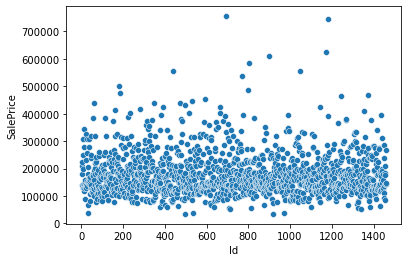

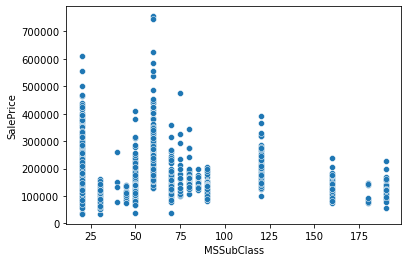

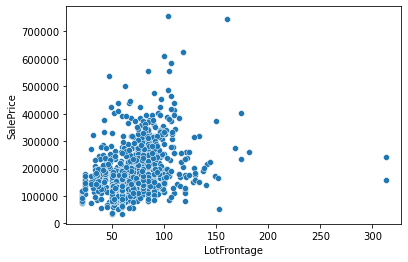

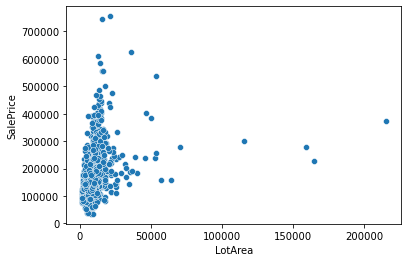

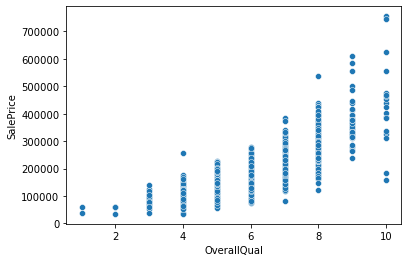

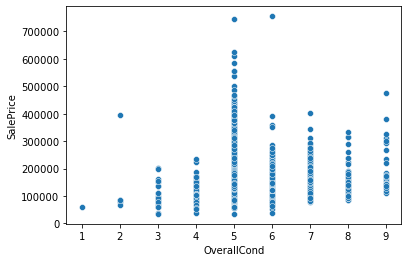

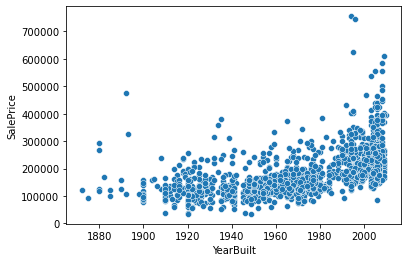

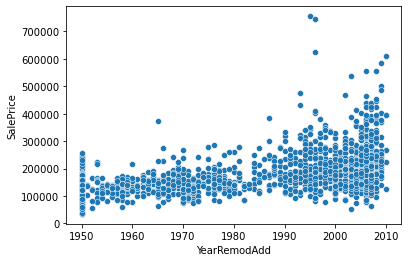

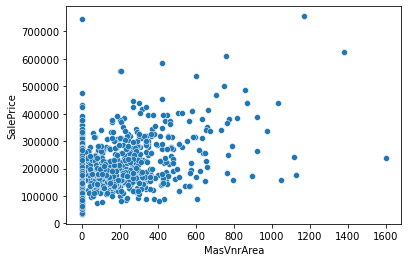

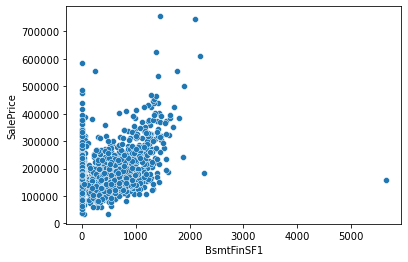

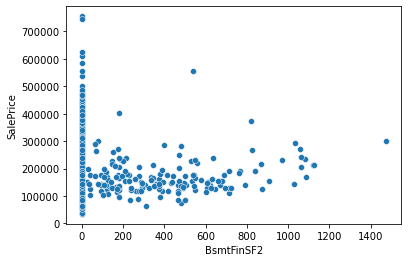

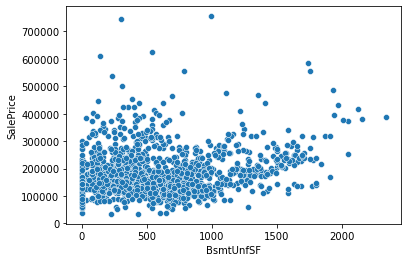

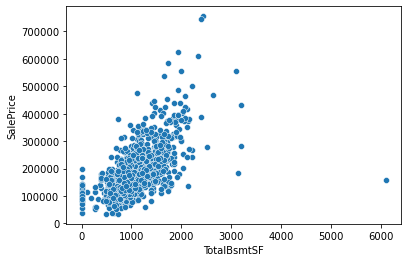

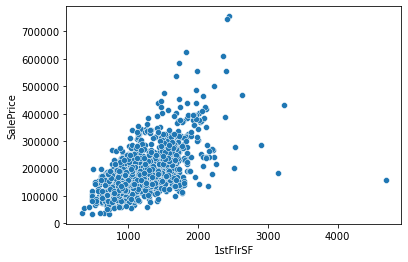

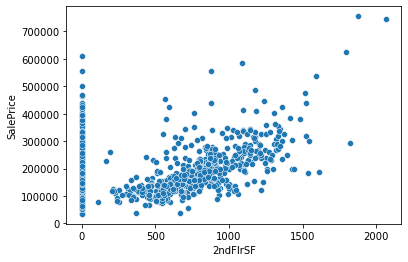

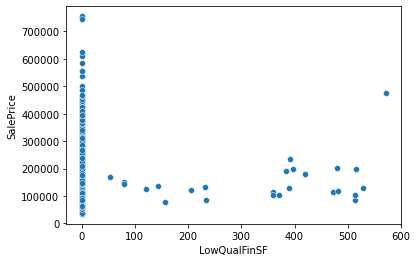

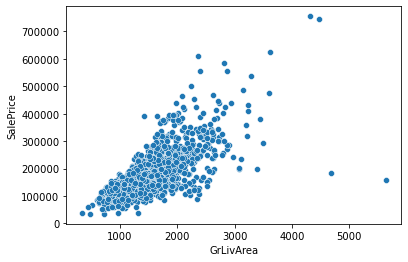

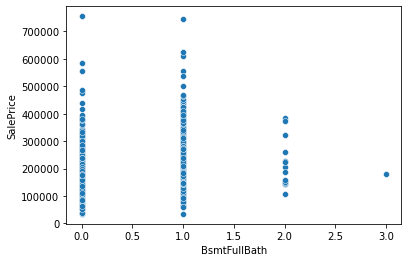

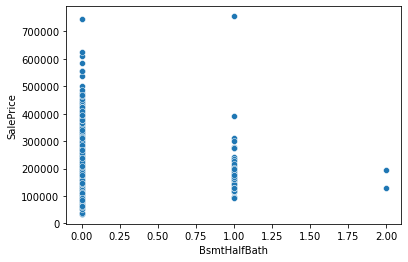

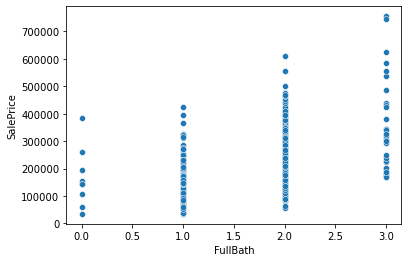

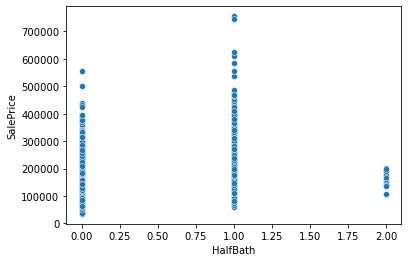

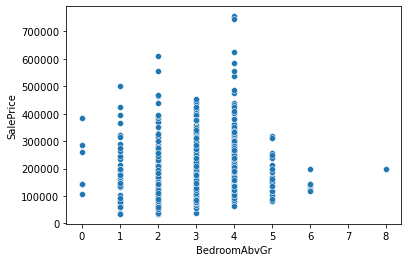

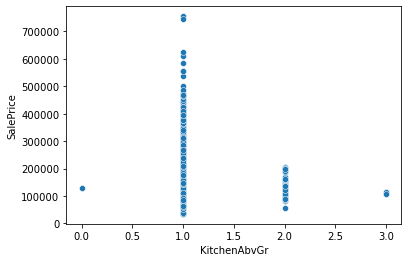

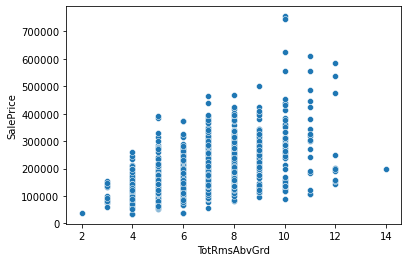

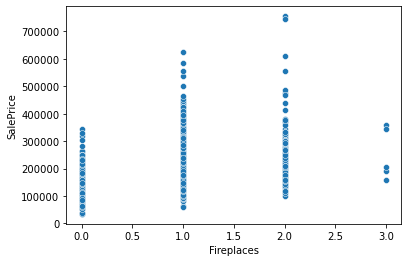

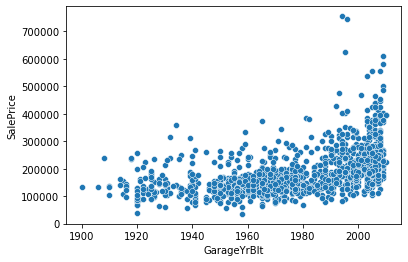

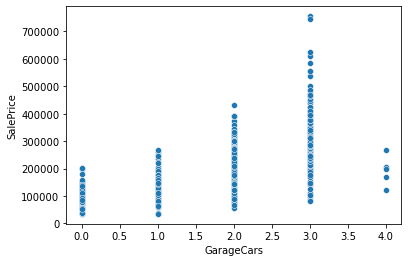

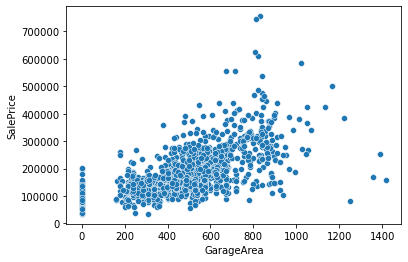

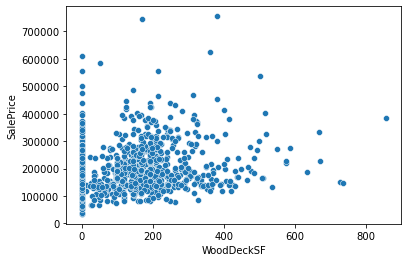

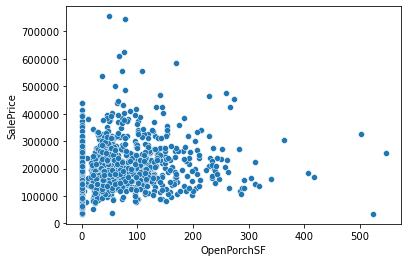

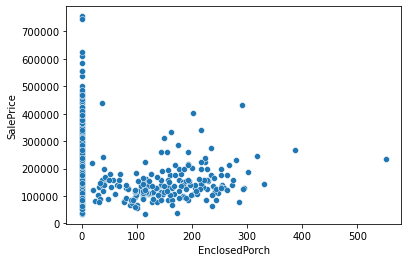

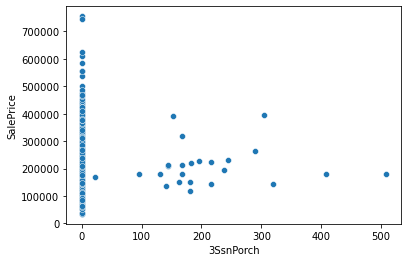

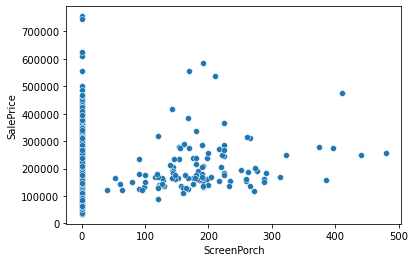

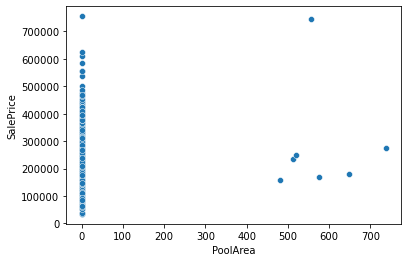

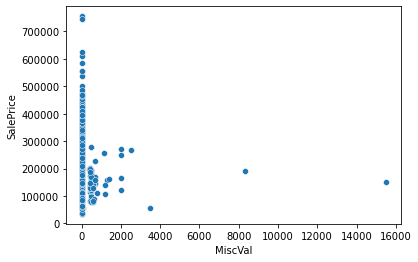

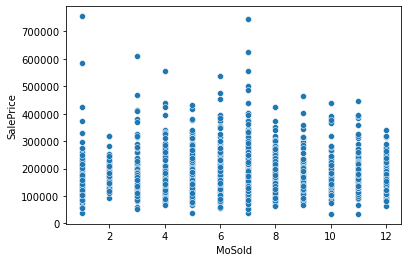

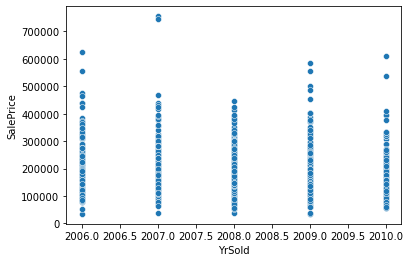

In [28]:
for i in num_cols_features:
    sns.scatterplot(x=num_cols_features[i], y=target)
    plt.show()

#####  Id, MSSubClass, LotQuanFinSF,  BsmtFullBath, BsmtHalfBath, FullBath, HalfBath, BedroomAbvGr, KitchenAbvGr, TotRmsAbvGrd, Fireplaces, GarageYrBlt, GarageCars, EnclosedPorch, 3SsnPorch, ScreenPorch, PoolArea, MiscVal, MoSold, YrSold is not related linearly with SalePrice
#### LotFontage, Lotarea,  WoodDeckSF, OpenPorchSF, had some relation with SalePrice
### TotalBmsSF, OverallQual,BsmtFinSF1, 1stFlrSF, 2ndFlrSF, GrLivArea, GarageArea related linearly with SalePrice

18


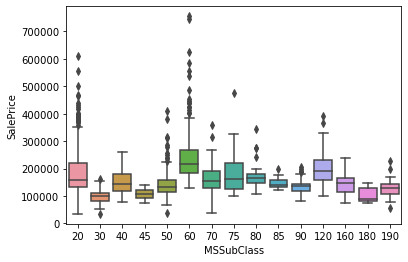

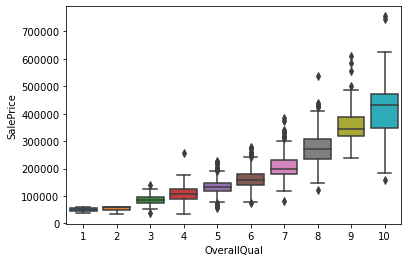

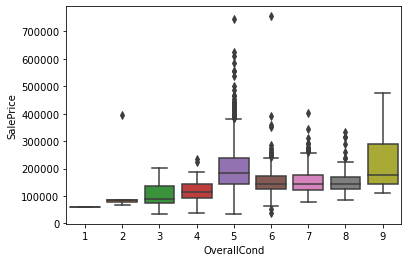

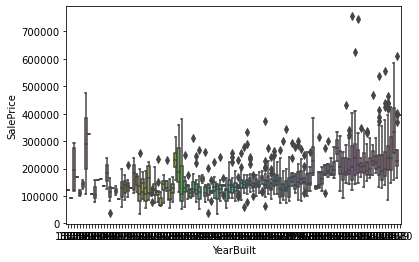

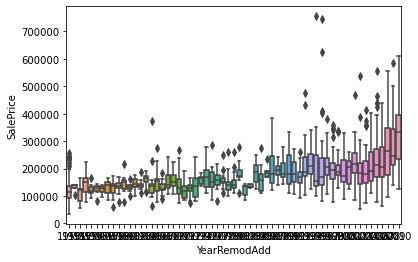

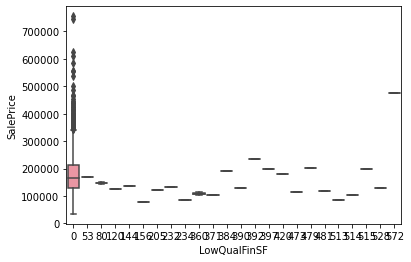

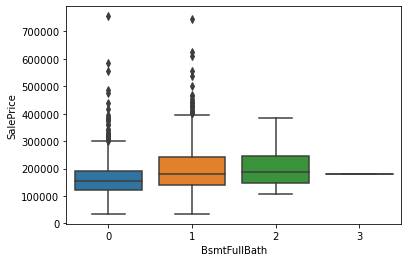

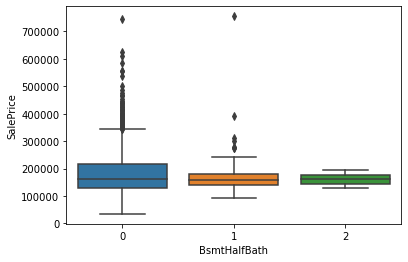

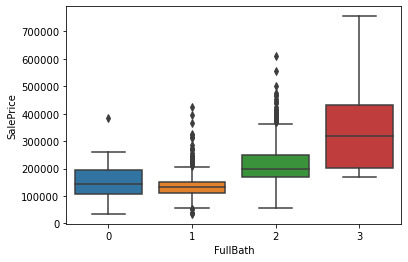

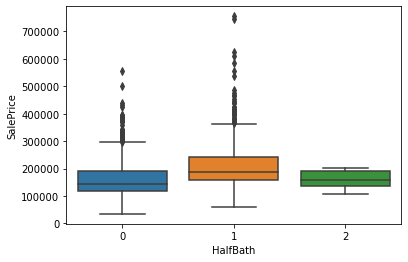

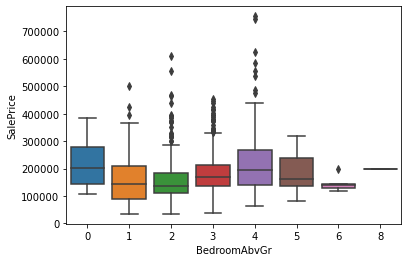

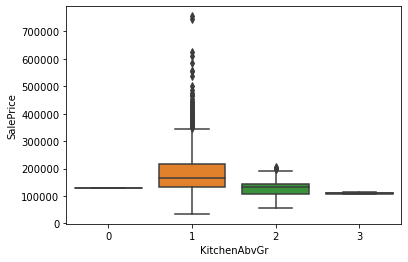

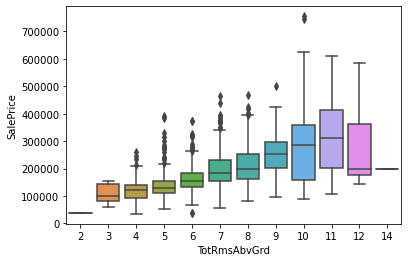

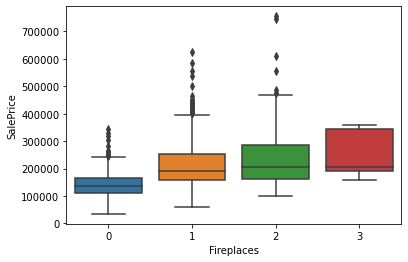

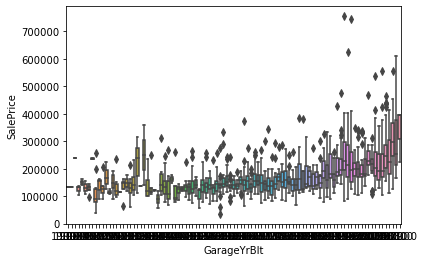

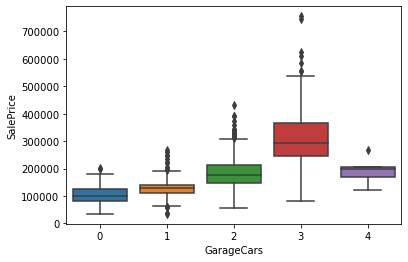

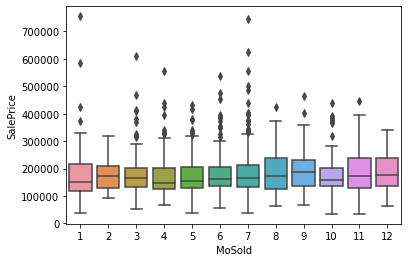

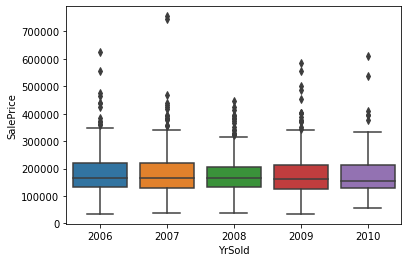

In [29]:
cols=['MSSubClass', 'OverallQual','OverallCond','YearBuilt','YearRemodAdd','LowQualFinSF','BsmtFullBath','BsmtHalfBath','FullBath','HalfBath','BedroomAbvGr','KitchenAbvGr','TotRmsAbvGrd','Fireplaces','GarageYrBlt','GarageCars','MoSold','YrSold']
print(len(cols))
for i in cols:
    sns.boxplot(x=num_cols_features[i], y=target)
    plt.show()


#### Pricing factors: 3 full bath's, 2 fireplaces, 3 garages, overall quality, recently built houses had higher prices.

# 2.2 Categorical Variables

In [289]:
cat_fea=df.select_dtypes(include='object')
cat_fea.head()

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
0,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
1,RL,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
2,RL,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
3,RL,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,...,Detchd,Unf,TA,TA,Y,NaN,NaN,NaN,WD,Abnorml
4,RL,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal


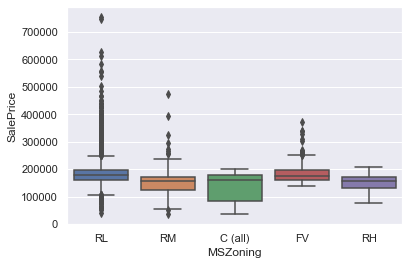

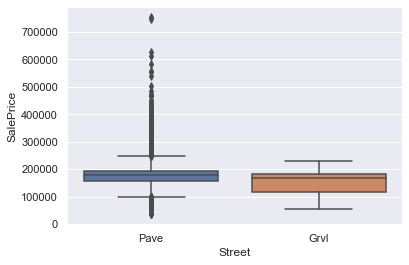

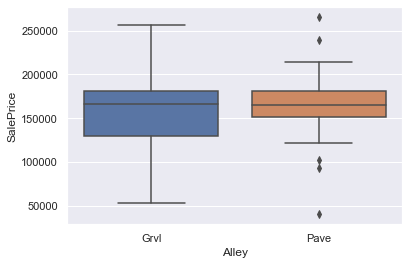

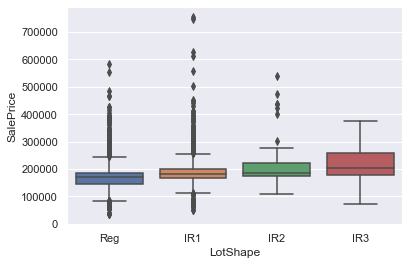

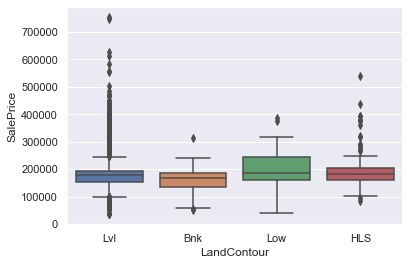

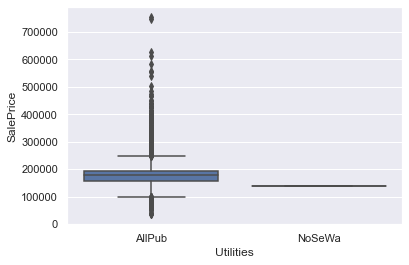

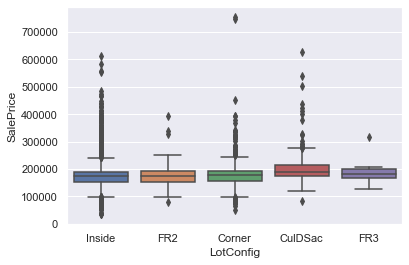

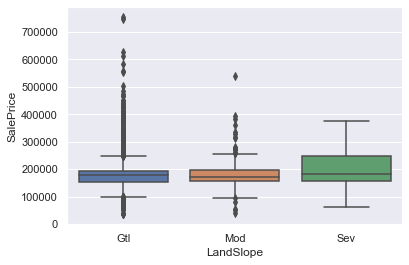

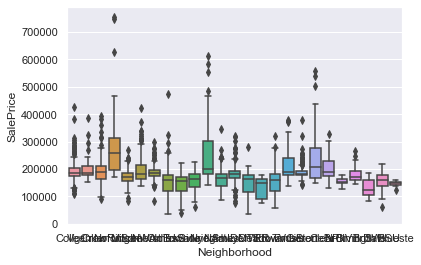

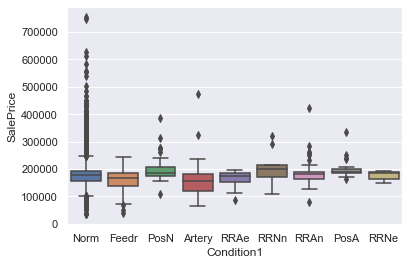

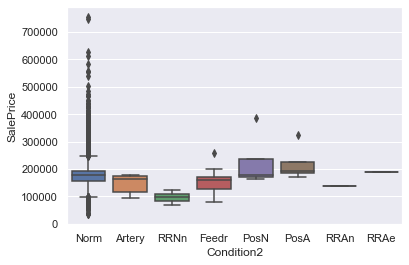

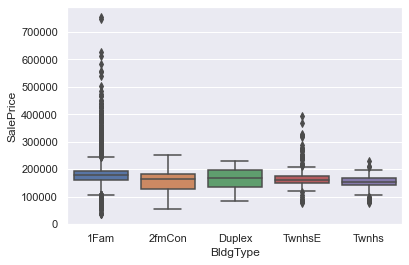

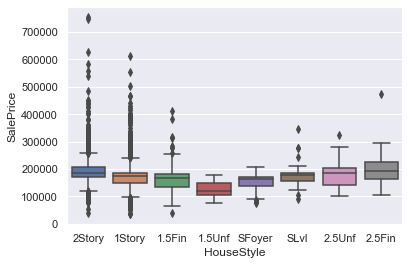

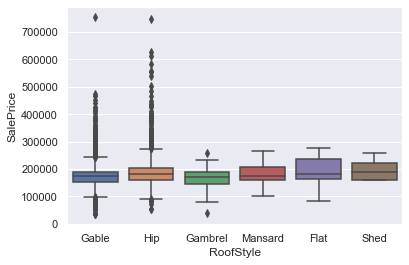

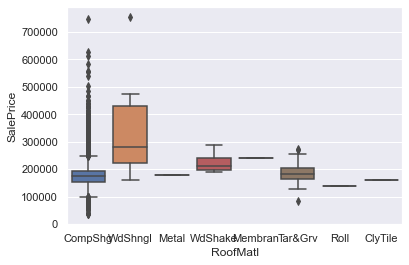

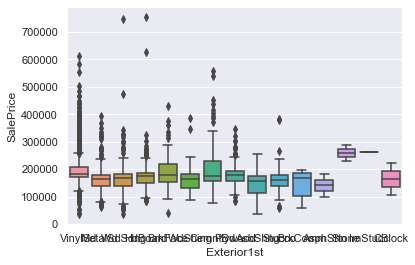

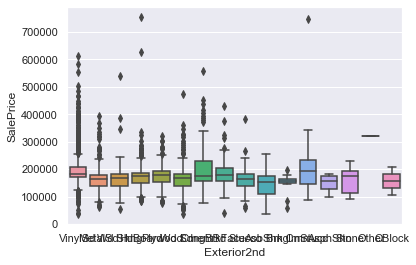

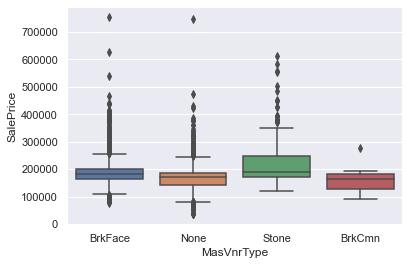

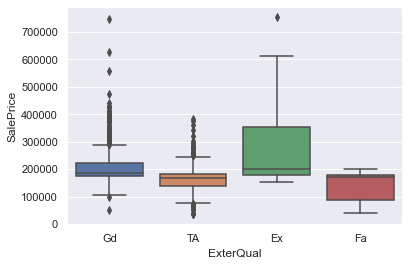

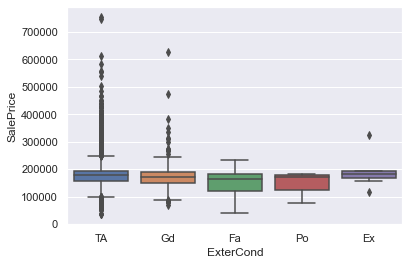

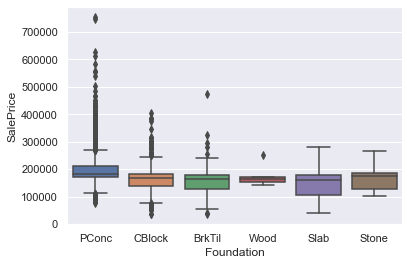

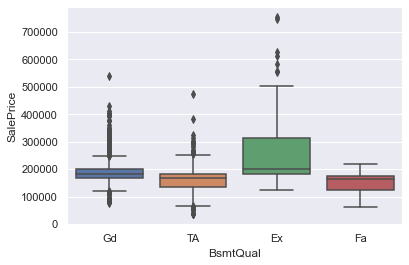

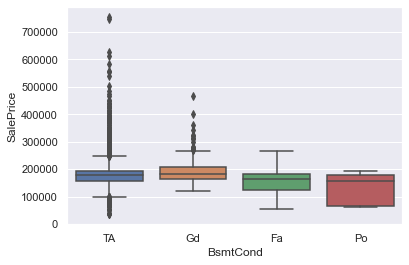

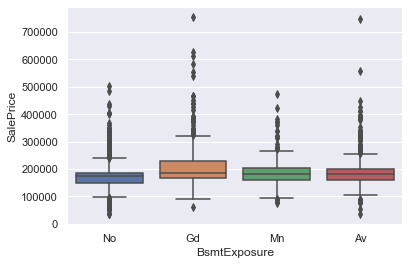

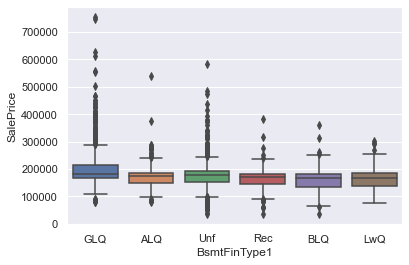

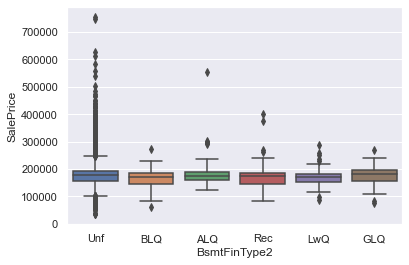

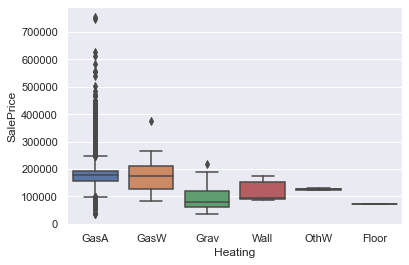

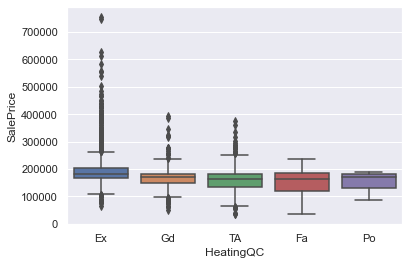

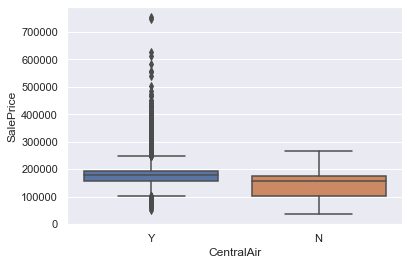

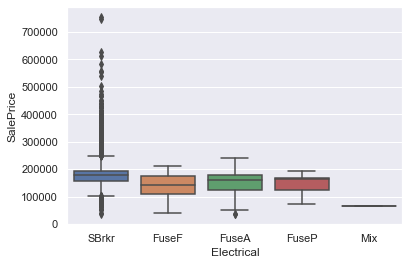

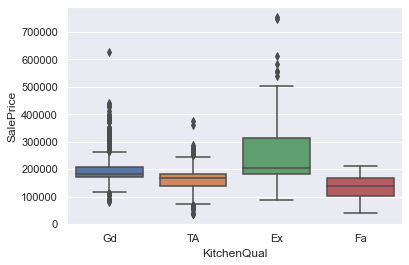

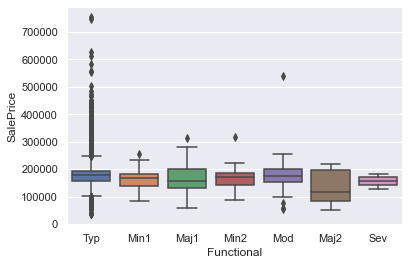

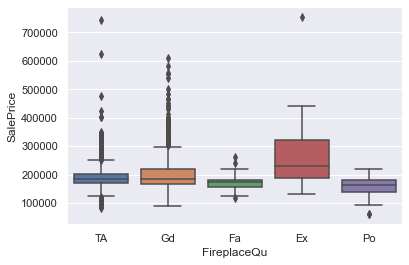

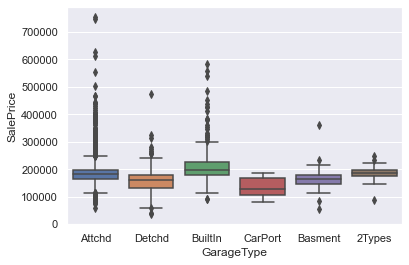

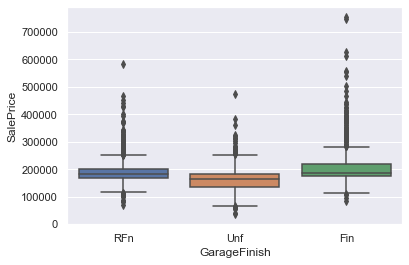

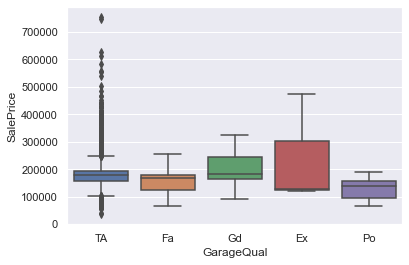

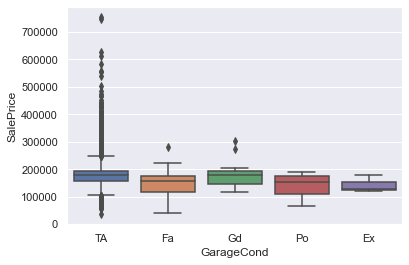

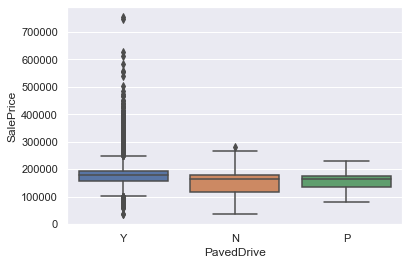

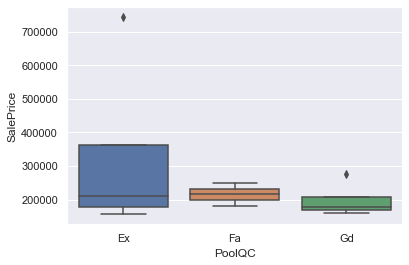

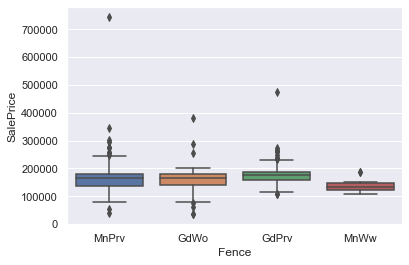

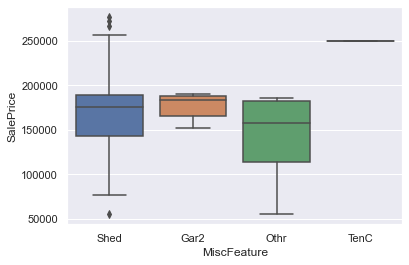

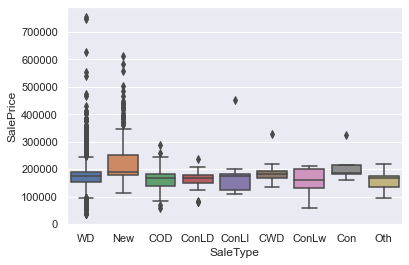

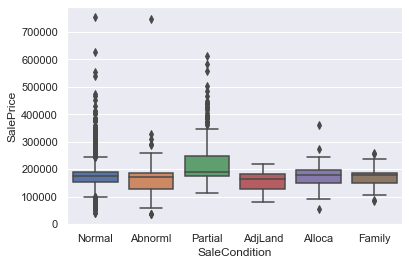

In [290]:
for j in cat_fea:
    sns.boxplot(x=cat_fea[j], y=y)
    plt.show()

# 2.3 Correlation matrix

In [444]:
#df.head()

<AxesSubplot:>

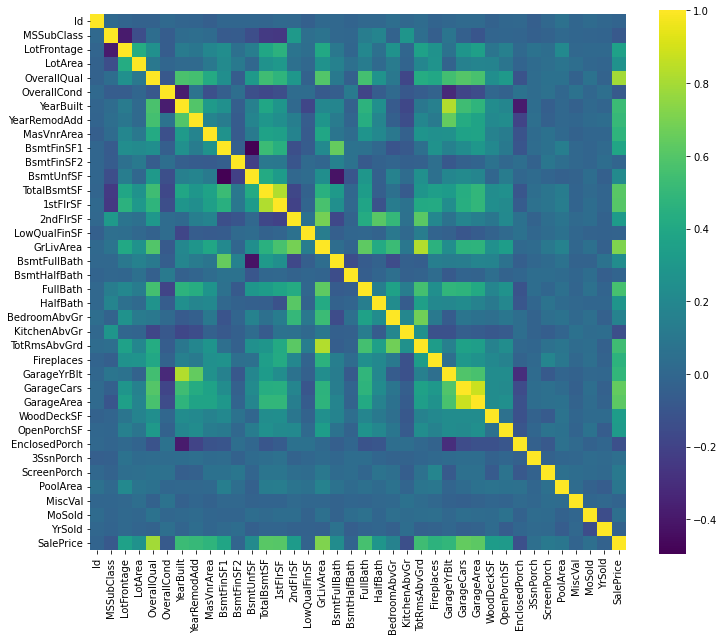

In [30]:
corr_mat=df.corr()
f,ax=plt.subplots(figsize=(12,10))
sns.heatmap(corr_mat, cmap='viridis', square=True)

# 2.4 Plot top 10 correlated features with values

Index(['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea',
       'TotalBsmtSF', '1stFlrSF', 'FullBath', 'TotRmsAbvGrd', 'YearBuilt'],
      dtype='object')


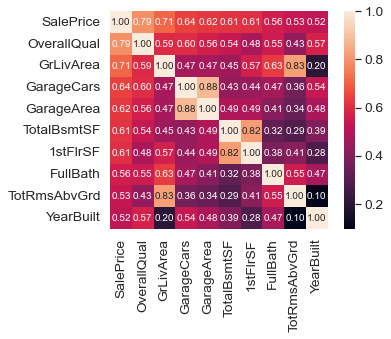

In [31]:
#saleprice correlation matrix
k = 10 #number of variables for heatmap
cols = corr_mat.nlargest(k, 'SalePrice')['SalePrice'].index
print(cols)
cm = np.corrcoef(df[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

#### Summary: OverallQual, GrLivArea are more correlated with SalePrice. GarageCars and GarageArea seems to be colinear features, will have same info means # of cars fit in Garage depends on Garage Size. So, keep only GarageCars column. Similary, TotalBsmtSF and 1stFlrSF are coliniear, keep TotalBsmtSF column. FullBath, TotRmsAbvGrd, Year Built seem correlated with Sale price 

# 2.4 Handling missing data

In [32]:
miss_sum=df.isnull().sum()
perc_miss=(df.isnull().sum()/df.isnull().count())*100
missing=pd.concat([miss_sum,perc_miss], axis=1, keys=['Sum_of_missing', 'Percent_missing'])
data=missing.reset_index().sort_values(['Percent_missing'], ascending=False).head(35)
data

,index,Sum_of_missing,Percent_missing
72,PoolQC,1453,99.520548
74,MiscFeature,1406,96.301370
6,Alley,1369,93.767123
73,Fence,1179,80.753425
57,FireplaceQu,690,47.260274
3,LotFrontage,259,17.739726
59,GarageYrBlt,81,5.547945
64,GarageCond,81,5.547945
58,GarageType,81,5.547945
60,GarageFinish,81,5.547945


#### Consider removing features with >15% missing. Also, these are not important features determining house prices.All the garage features except GarageCars had ~5% similar missing data, since GarageCars had less missing data and useful info, I am keeping this column and remove rest of the Garage features. Similarly, keep BsmtSF and remove (BsmtFinType2, BsmtExposure, BsmtQual, BsmtCond, BsmtFinType1 features). MasVnrArea and MasVnrType are not important features, so dropping them doesn't hurt. Finally, some feature had just 1 missing value, so I am dropping those rows.

### 2.4 Summary of handling missing data: Dropping all features with >23 missing values.

In [33]:
print(list(data['index'][:18])) # slice features with high missing data
cols_drop=list(data['index'][:18])
data_set=df.drop(df[cols_drop], axis=1)
data_set.head()

['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 'LotFrontage', 'GarageYrBlt', 'GarageCond', 'GarageType', 'GarageFinish', 'GarageQual', 'BsmtFinType2', 'BsmtExposure', 'BsmtQual', 'BsmtCond', 'BsmtFinType1', 'MasVnrArea', 'MasVnrType']


,Id,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,2,2008,WD,Normal,208500
1,2,20,RL,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,0,5,2007,WD,Normal,181500
2,3,60,RL,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,9,2008,WD,Normal,223500
3,4,70,RL,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,272,0,0,0,0,2,2006,WD,Abnorml,140000
4,5,60,RL,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,0,12,2008,WD,Normal,250000


In [34]:
data_set.shape

(1460, 63)

In [35]:
# drop rows with missing values (since some features had 1-4 missing values)
data_set=data_set.dropna()
# Making sure no missing data exist
data_set.isnull().sum().sort_values(ascending=False).head()

Id              0
Fireplaces      0
1stFlrSF        0
2ndFlrSF        0
LowQualFinSF    0
dtype: int64

# 2.5 Handling Outliers

## 2.5.1 Univariate plot

<AxesSubplot:xlabel='SalePrice', ylabel='Density'>

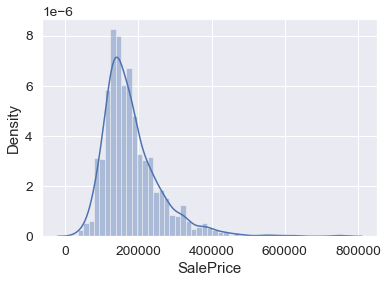

In [36]:
sns.distplot(data_set.SalePrice)

## 2.5.2 Bivariate plots with key features 

### 2.5.2.1 Detect and drop Outliers from key features

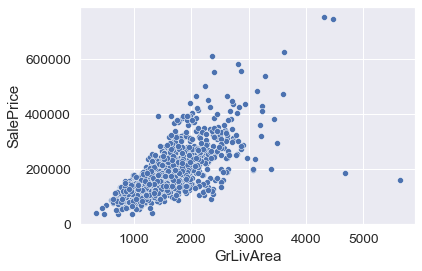

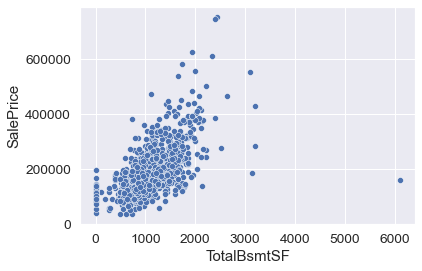

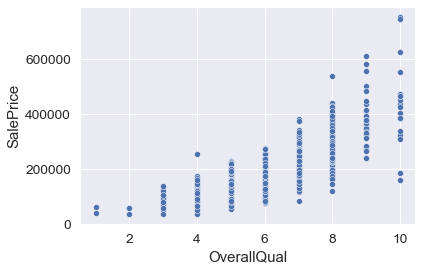

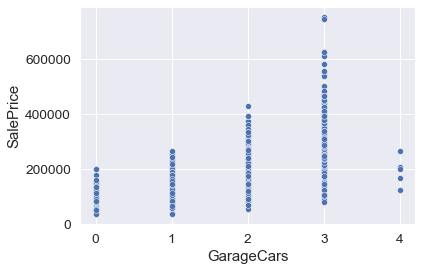

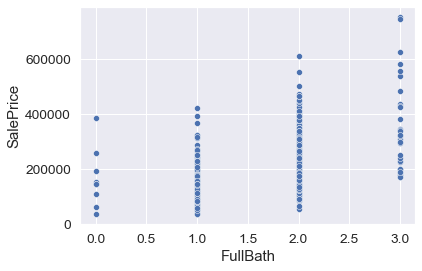

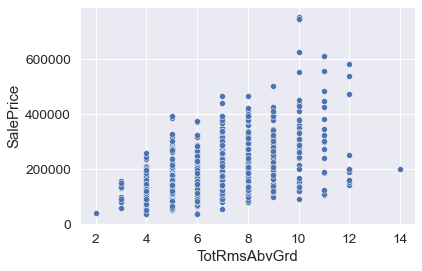

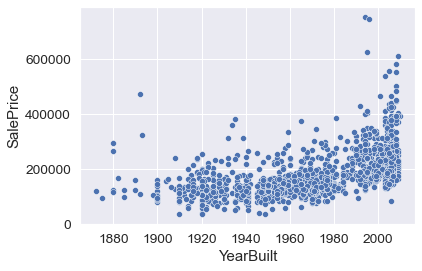

In [37]:
key_features=['GrLivArea','TotalBsmtSF','OverallQual','GarageCars','FullBath', 'TotRmsAbvGrd', 'YearBuilt']
for i in key_features:
    sns.scatterplot(x=data_set[i], y=data_set['SalePrice'])
    plt.show()

#### Outliers are detected with GrLivArea >4500 (but two obs's on top of plot seems to follow linear trend). TotalBsmtSF>6000; TotRmsAbvGrd>12

In [38]:
data_set.shape

(1459, 63)

In [48]:
# drop rows with GrLivArea >4000 but SalePrice <185000 to keep top outliers
df1 = data_set.drop(data_set
                   [(data_set['GrLivArea']>4000) & (data_set['SalePrice']<185000)].index)

df1.shape

(1457, 63)

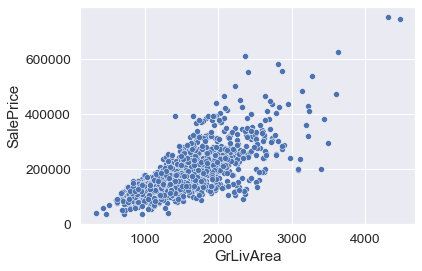

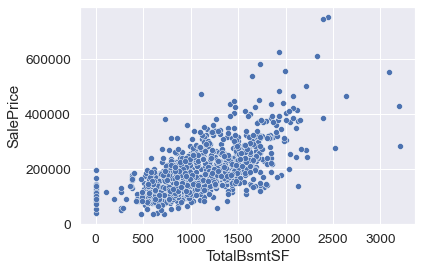

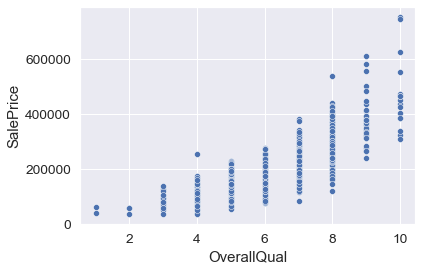

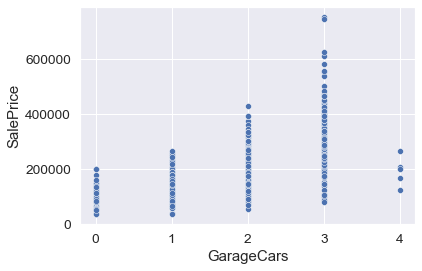

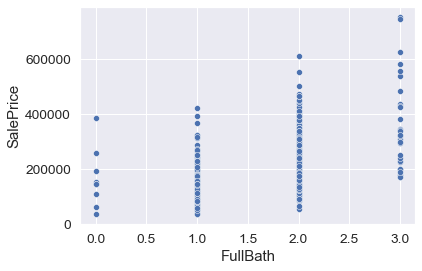

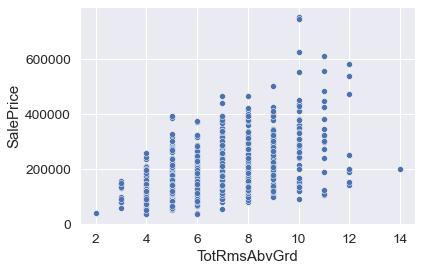

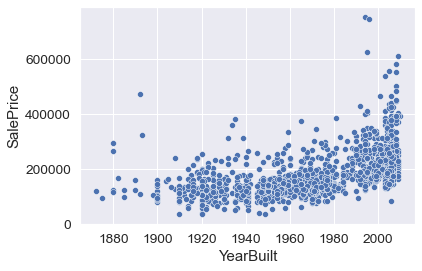

In [49]:
## making sure if outliers are removed from key features

key_features=['GrLivArea','TotalBsmtSF','OverallQual','GarageCars','FullBath', 'TotRmsAbvGrd', 'YearBuilt']
for i in key_features:
    sns.scatterplot(x=df1[i], y=df1['SalePrice'])
    plt.show()

#### TotalBsmtSF>3000 may not be outliers, so not removing them

# 3. Preprocessing

## 3.1 check distribution of target variable

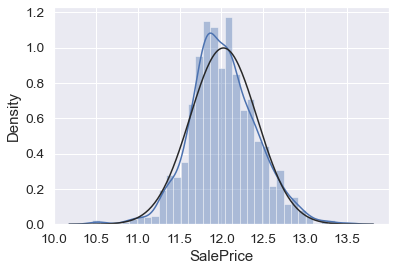

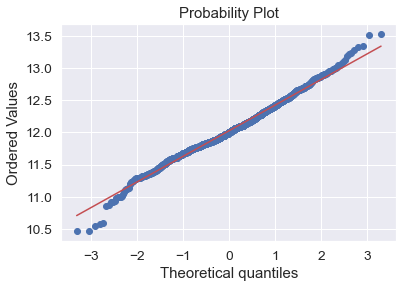

In [51]:
# histogram and probability plot of target variable
sns.distplot(df1['SalePrice'], fit=norm)
fig=plt.figure()
res=stats.probplot(df1['SalePrice'], plot=plt)

### SalePrice is not normally distributed, and had positive skewness. So, apply log transformation

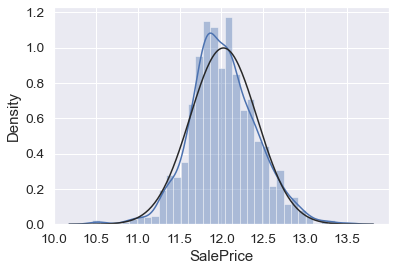

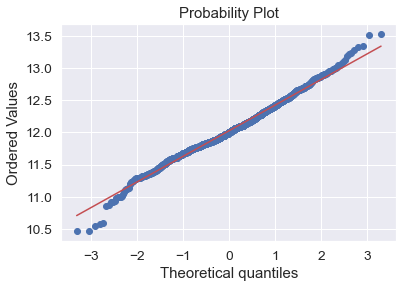

In [50]:
# apply log transformation to target variable to make normally distributed
df1['SalePrice']=np.log(df1['SalePrice'])

# check if log transformation improved histogram and prob distribution
sns.distplot(df1['SalePrice'], fit=norm)
fig=plt.figure()
res=stats.probplot(df1['SalePrice'], plot=plt)

### Yes, SalePrice is normally distributed........

# 3.2 how about distribution of key features? GrLivArea, ?


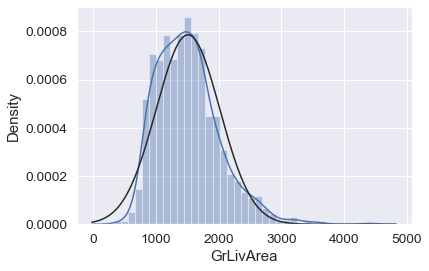

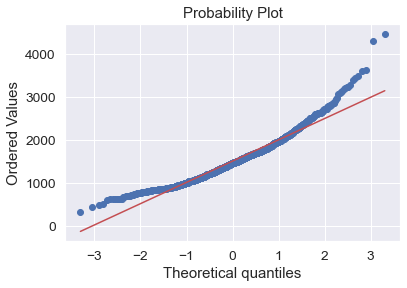

In [52]:
sns.distplot(df1['GrLivArea'], fit=norm);
fig=plt.figure()
res=stats.probplot(df1['GrLivArea'], plot=plt)

### GrLivArea is not normally distributed, and had positive skewness. So, apply log transformation

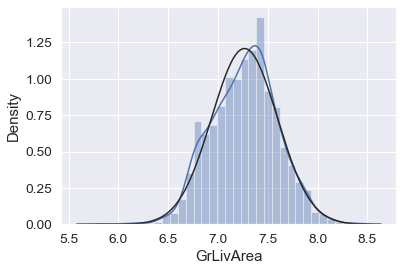

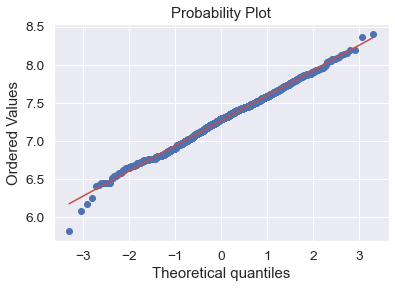

In [53]:
# apply log transformation to variable to make normally distributed
df1['GrLivArea'] = np.log(df1['GrLivArea'])

# check if log transformation improved histogram and prob distribution
sns.distplot(df1['GrLivArea'], fit=norm)
fig=plt.figure()
res=stats.probplot(df1['GrLivArea'], plot=plt)

## 3.3 how about distribution of key features? TotalBsmtSF?

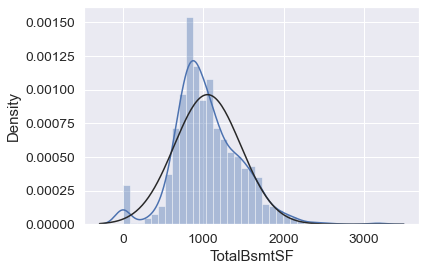

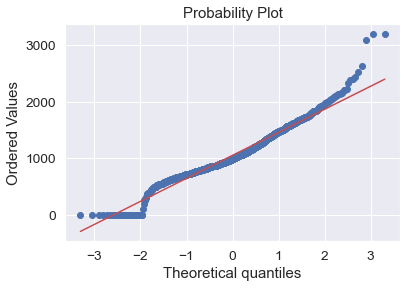

In [54]:
sns.distplot(df1['TotalBsmtSF'], fit=norm)
fig=plt.figure()
res=stats.probplot(df1['TotalBsmtSF'], plot=plt)

In [56]:
df1['TotalBsmtSF'].value_counts()

0       37
864     35
672     17
912     15
1040    14
        ..
654      1
1838     1
1581     1
707      1
1542     1
Name: TotalBsmtSF, Length: 719, dtype: int64

### TotalBsmtSF is not normally distributed had positive skewness. BUT starts with 0 (houses without basement); 0 doesn't allow log transformation; So, add 1 sft to all values of TotalBsmtSF column, adding 1 sft doesn't inflate values much, then applied log transformation.

In [58]:
df1.replace([np.inf, -np.inf], np.nan, inplace=True)
#df1['TotalBsmtSF'] = df1['TotalBsmtSF']+1.00000

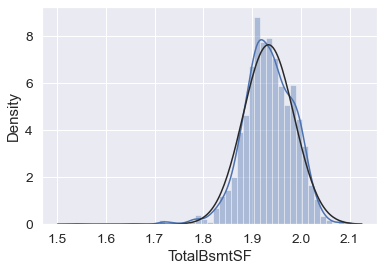

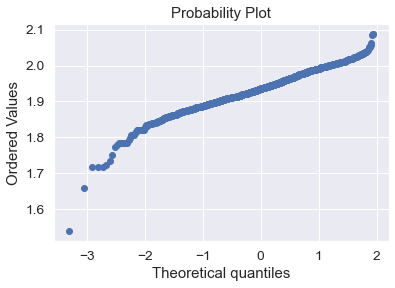

In [59]:
# apply log transformation to variable to make normally distributed
df1['TotalBsmtSF']=np.log(df1['TotalBsmtSF'])

# check if log transformation improved histogram and prob distribution
sns.distplot(df1['TotalBsmtSF'], fit=norm)
fig=plt.figure()
res=stats.probplot(df1['TotalBsmtSF'], plot=plt)


### TotalBsmtSF is not normally distributed had positive skewness. BUT starts with 0 (houses without basement); 0 doesn't allow log transformation; 
1st convert it to binary variable (area>0 give 1 has basement; area=0 give 0 no basement).

In [425]:
#create column for new variable (one is enough because it's a binary categorical feature)
#if area>0 it gets 1, for area==0 it gets 0
#df1['HasBsmt'] = pd.Series(len(df1['TotalBsmtSF']), index=df1.index)
#df1['HasBsmt'] = 0 
#df1.loc[df1['TotalBsmtSF']>0,'HasBsmt'] = 1

In [427]:
# log transform data
#df1.loc[df1['HasBsmt']==1,'TotalBsmtSF'] = np.log(df1['TotalBsmtSF'])

#histogram and normal probability plot
#sns.distplot(df1[df1['TotalBsmtSF']>0]['TotalBsmtSF'], fit=norm);
#fig = plt.figure()
#res = stats.probplot(df1[df1['TotalBsmtSF']>0]['TotalBsmtSF'], plot=plt)


<AxesSubplot:xlabel='GrLivArea', ylabel='SalePrice'>

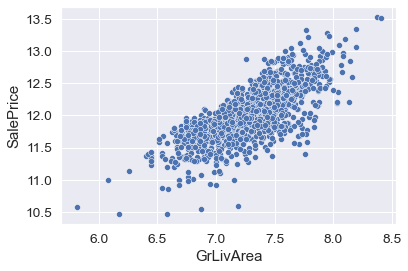

In [60]:
sns.scatterplot(x=df1['GrLivArea'], y=df1['SalePrice'])

<AxesSubplot:xlabel='TotalBsmtSF', ylabel='SalePrice'>

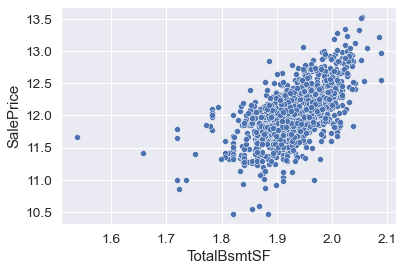

In [61]:
#sns.scatterplot(x=df1[df1['TotalBsmtSF']>0]['TotalBsmtSF'], y=df1['SalePrice'])

sns.scatterplot(x=df1['TotalBsmtSF'], y=df1['SalePrice'])

In [62]:
df1.head()

,Id,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,2,2008,WD,Normal,12.247694
1,2,20,RL,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,0,5,2007,WD,Normal,12.109011
2,3,60,RL,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,9,2008,WD,Normal,12.317167
3,4,70,RL,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,272,0,0,0,0,2,2006,WD,Abnorml,11.849398
4,5,60,RL,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,0,12,2008,WD,Normal,12.429216


In [63]:
df1.shape

(1457, 63)

## Then handling categorical data of df1

In [64]:
# 3.4 Create dummy variables to categorical variables
dummies=pd.get_dummies(df1)
dummies.head()

,Id,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,1,60,8450,7,5,2003,2003,706,0,150,...,0,0,0,1,0,0,0,0,1,0
1,2,20,9600,6,8,1976,1976,978,0,284,...,0,0,0,1,0,0,0,0,1,0
2,3,60,11250,7,5,2001,2002,486,0,434,...,0,0,0,1,0,0,0,0,1,0
3,4,70,9550,7,5,1915,1970,216,0,540,...,0,0,0,1,1,0,0,0,0,0
4,5,60,14260,8,5,2000,2000,655,0,490,...,0,0,0,1,0,0,0,0,1,0


In [65]:
#check if column contains infinite value, replaced the +/-inf values into nan's and droped rows with nan's
dummies.replace([np.inf, -np.inf], np.nan, inplace=True)
dummies.dropna()
dummies.shape

(1457, 221)

In [72]:
# check if any missing values in features after preprocessing
dummies.isnull().sum().sort_values(ascending=False)

TotalBsmtSF              37
Id                        0
Exterior2nd_Other         0
Exterior1st_Wd Sdng       0
Exterior1st_WdShing       0
                         ..
Neighborhood_OldTown      0
Neighborhood_SWISU        0
Neighborhood_Sawyer       0
Neighborhood_SawyerW      0
SaleCondition_Partial     0
Length: 221, dtype: int64

In [81]:
dummies['TotalBsmtSF']=dummies['TotalBsmtSF'].replace(np.nan, 1)

In [82]:
#dummies['TotalBsmtSF']=dummies['TotalBsmtSF']+1.000000

dummies.isnull().sum().sort_values(ascending=False)

Id                       0
Exterior2nd_Other        0
Exterior1st_Wd Sdng      0
Exterior1st_WdShing      0
Exterior2nd_AsbShng      0
                        ..
Neighborhood_OldTown     0
Neighborhood_SWISU       0
Neighborhood_Sawyer      0
Neighborhood_SawyerW     0
SaleCondition_Partial    0
Length: 221, dtype: int64

In [83]:
dummies.shape

(1457, 221)

## Final dataset

In [84]:
# Rearrange columns of dummies so that SalePrice is last column

cols=dummies.columns.tolist() # list of dummies columns
#print(cols)
index=dummies.columns.get_loc("SalePrice") # index of SalePrice column
print(index)

new_cols=cols[0:index] + cols[index+1:]+ cols[index:index+1] # Rearrange columns of dummies so that SalePrice is last column
final_data=dummies[new_cols]
final_data.head()

34


,Id,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,SalePrice
0,1,60,8450,7,5,2003,2003,706,0,150,...,0,0,1,0,0,0,0,1,0,12.247694
1,2,20,9600,6,8,1976,1976,978,0,284,...,0,0,1,0,0,0,0,1,0,12.109011
2,3,60,11250,7,5,2001,2002,486,0,434,...,0,0,1,0,0,0,0,1,0,12.317167
3,4,70,9550,7,5,1915,1970,216,0,540,...,0,0,1,1,0,0,0,0,0,11.849398
4,5,60,14260,8,5,2000,2000,655,0,490,...,0,0,1,0,0,0,0,1,0,12.429216


In [85]:
final_data.shape

(1457, 221)

# 4. Train Model

## Separating features (X) and target variable (y)

In [112]:
# 4.1 split the data
X=final_data.iloc[:,:-1].values
y=final_data['SalePrice'].values
X

array([[1.000e+00, 6.000e+01, 8.450e+03, ..., 0.000e+00, 1.000e+00,
        0.000e+00],
       [2.000e+00, 2.000e+01, 9.600e+03, ..., 0.000e+00, 1.000e+00,
        0.000e+00],
       [3.000e+00, 6.000e+01, 1.125e+04, ..., 0.000e+00, 1.000e+00,
        0.000e+00],
       ...,
       [1.458e+03, 7.000e+01, 9.042e+03, ..., 0.000e+00, 1.000e+00,
        0.000e+00],
       [1.459e+03, 2.000e+01, 9.717e+03, ..., 0.000e+00, 1.000e+00,
        0.000e+00],
       [1.460e+03, 2.000e+01, 9.937e+03, ..., 0.000e+00, 1.000e+00,
        0.000e+00]])

In [113]:
X.shape

(1457, 220)

In [114]:
y

array([12.24769432, 12.10901093, 12.31716669, ..., 12.49312952,
       11.86446223, 11.90158345])

In [115]:
y.shape

(1457,)

# Train, Test, split data

In [116]:
X_train,X_test,y_train,y_test=train_test_split(X, y, test_size=0.3, random_state=0)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1019, 220)
(438, 220)
(1019,)
(438,)


# Feature Scaling

In [118]:
#Call the StandardScaler`s fit method on `X_tr` to fit the scaler
#then use it's `transform()` method to apply the scaling to both the train and test split
#data (`X_tr` and `X_te`), naming the results `X_tr_scaled` and `X_te_scaled`, respectively
scaler = StandardScaler()
scaler.fit(X_train)
X_tr_scaled = scaler.transform(X_train)
X_te_scaled = scaler.transform(X_test)

## 4.2 Multiple Linear Regression model

y= a1x1 + a2x2 + a3x3+....+b (linear reg minimizes a loss function (OLS) while choosing coefficients for fitting the model in sklearn. 

In [123]:
# instantiate linearregression
lr=LinearRegression()
# fit leniar regression on training data
lr.fit(X_tr_scaled, y_train)


y_tr_pred = lr.predict(X_tr_scaled)
y_te_pred = lr.predict(X_te_scaled)
# predict on test data
#y_pred=lr.predict(X_test)

score(y_train, y_tr_pred)

#print('R^2: {}'.format(lr.score(y_train, y_tr_pred)))
#print('R^2: {}'.format(lr.score(y_test, y_te_pred)))

      
#rmse=np.sqrt(mean_squared_error(y_test, y_pred))
#print("Root Mean Square Error: {}".format(rmse))

NameError: name 'score' is not defined

In [101]:
y_pred[:10]

array([11.83122253, 11.9577179 , 11.46699524, 11.81169128, 12.61909485,
       11.92420959, 12.08110046, 11.74990845, 11.88189697, 12.19850159])

# 4.2.1 Five fold cross validation

Cross-validation is a vital step in evaluating a model.

In [103]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression

lr=LinearRegression()
# compute 5-fold cross-val scores
cv_scores=cross_val_score(lr, X, y, cv=5)

print("5-fold cross val scores (i.e R^2 values):{}". format(cv_scores))
print('Mean cross val score or mean R^2 value: {}'.format(np.mean(cv_scores)))

5-fold cross val scores (i.e R^2 values):[-3.68276644e+20 -1.78618513e+19 -2.92124509e+17 -5.94875735e+18
 -1.13639173e+21]
Mean cross val score or mean R^2 value: -3.0575422229156784e+20


### Large coefficients can lead to overfitting of Linear Regression; So, Regularization can penalize overfitting by handling colinearity. 

# 4.3. Ridge Regression
Parameter is alpha like k in KNN (alpha=0 leads to overfitting, very high alpha leads to underfitting) 

In [104]:
ridge = RidgeCV(alphas = [0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1, 3, 6, 10, 30, 60])
ridge.fit(X_train, y_train)
alpha = ridge.alpha_
print('Best alpha',alpha)

# predict on training data
y_trpred=ridge.predict(X_train)
# predict on test data
y_pred=ridge.predict(X_test)
print('R^2 value:{}'.format(ridge.score(X_test, y_test)))
rmse=np.sqrt(mean_squared_error(y_test, y_pred))
print("Root Mean Square Error: {}".format(rmse))

Best alpha 1.0
R^2 value:0.9267566695234545
Root Mean Square Error: 0.10653692000780458


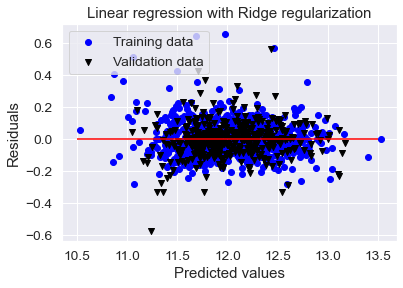

In [105]:
# Plot residuals
plt.scatter(y_trpred, y_trpred - y_train, c = "blue",  label = "Training data")
plt.scatter(y_pred, y_pred - y_test, c = "black", marker = "v", label = "Validation data")
plt.title("Linear regression with Ridge regularization")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = 10.5, xmax = 13.5, color = "red")
plt.show()

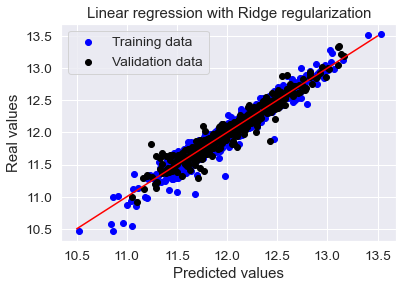

In [106]:
# Plot predictions - Real values
plt.scatter(y_trpred, y_train, c = "blue",  label = "Training data")
plt.scatter(y_pred, y_test, c = "black",  label = "Validation data")
plt.title("Linear regression with Ridge regularization")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([10.5, 13.5], [10.5, 13.5], c = "red")
plt.show()

# 4.4. Lasso Regression


In [107]:
from sklearn.linear_model import Lasso
lasso=Lasso(alpha=0.1, normalize=True)
lasso.fit(X_train, y_train)
y_pred=lasso.predict(X_test)
print('R^2 value:{}'.format(lasso.score(X_test, y_test)))

R^2 value:-0.00011015472492204026
